# M33 Stellar Disk Morphology

Trevor Smith

ASTR 400B Spring 2020 with Prof. Gurtina Besla

In this project we will analyse the future morphological evolution of M33. We will check for spiral patterns in the disk and measure the axial ratio of M33 for the current day and 11 Gyr in the future.

In [1]:
# import python libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import astropy.units as u

# plotting magic
%matplotlib inline

# import my modules
from ReadFile import Read
from CenterOfMass2 import CenterOfMass
from DensityContour import density_contour

## Read in Particle Data and Switch to Desired Frame of Reference

We will define a function to do the following:  
--Read in raw particle data from simulation output txt file  
--Calculate the center of mass position, translate coordinates so this coincides with the origin  
--Calculate the total angular momentum of M33, rotate coordinates so that the direction of this 
vector lines up with our z-axis. This should rotate the plane of M33s disk parallel to the x-y plane.  
--Return the positions of all M33 stellar particles in this new frame of reference

In [2]:
def RotateFrame(posI,velI):
    """
    Function to rotate the position and velocity vectors so that the disk angular momentum is aligned with z axis.
    This function was created in ASTR 400B Lab 7
    Inputs:
        posI = Nx3 array of 3D particle positions
        velI = Nx3 array of 3D particle velocities
    Returns:
        Two Nx3 arrays of rotated particle positions and velocities
    """
    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))

    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel


def ParticlePositions(filename,maxr):
    """
    Function to read in particle positions and return them transformed into
    a more convenient frame of reference (outlined above).
    Inputs:
        filename = a string containing the file path to the simulation output file
        maxr = radius from the center of mass outside which we will discount particles
            this is to compensate for mass loss in our calculations
    Returns:
        an Nx3 array containing the 3D particle positions (kiloparsecs)
        1 row per particle, columns arranged as [x,y,z]
    """
    
    # create an instance of the CenterOfMass object
    # use disk stars only (ptype=2)
    # M33 has no bulge stars, so this will contain ALL stellar information
    COM = CenterOfMass(filename,2) 
    
    # calculate center of mass position and velocity
    delta = 0.1 # tolerance for the COM position to converge during the iterative calculation (kpc)
    VolDec = 4 # the fraction by which the max radius will be reduced in each iteration
    # we choose 4 rather than 2 for M33 to compensate for significant mass loss later in the simulation
    
    COMP = COM.COM_P(delta,VolDec) # COM position
    COMV = COM.COM_V(*COMP) # COM velocity
    
    # translate coordinates to the COM position
    # CenterOfMass functions return astropy quantities, need to use .value
    x = COM.x - COMP[0].value
    y = COM.y - COMP[1].value
    z = COM.z - COMP[2].value
    vx = COM.vx - COMV[0].value
    vy = COM.vy - COMV[1].value
    vz = COM.vz - COMV[2].value
    
    # to compensate for mass loss, take only particles within maxr
    maxr = 15 # kpc
    r = np.array([x,y,z]).T
    indices = np.asarray(np.linalg.norm(r,axis=1) < maxr).nonzero()
    r_cutoff = r[indices]
    v_cutoff = np.array([vx,vy,vz]).T[indices]
    
    # rotate frame of reference so that L||z
    # function expects two Nx3 arrays
    rnew, vnew = RotateFrame(r_cutoff,v_cutoff)
    
    # return positions in new frame of reference
    # Nx3 array
    return rnew

In [3]:
# use function above to read in particle positions at the initial and final timesteps
ri = ParticlePositions('HighRes/M33_000.txt',15)
rf = ParticlePositions('HighRes/M33_801.txt',15)

# shallow copies of position data for readability
xi = ri[:,0]
yi = ri[:,1]
zi = ri[:,2]
xf = rf[:,0]
yf = rf[:,1]
zf = rf[:,2]

## 2D Density Plots

Plot 2D normalized histograms. Axes display x and y position of particles. Colormap displays log of the particle density in each bin.  
Contours of constant density overlayed to aid in visual analysis.  
Ellipses were manually fit to the disk edge-on profile to demonstrate approximate axial ratios.

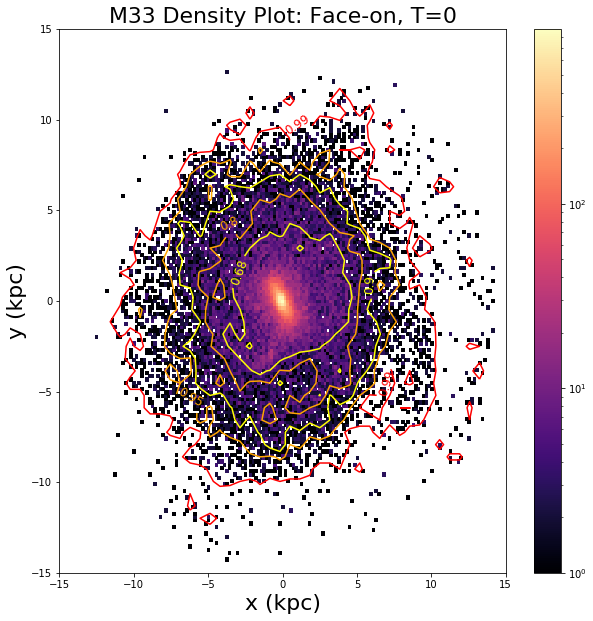

In [4]:
"""
T=0 Face-On Perpective
"""

# define histogram and contour resolution
histbins = 150
contourbins_x = 40
contourbins_y = 40

# create figure
fig, ax= plt.subplots(figsize=(10,10))
ax.set_title('M33 Density Plot: Face-on, T=0',fontsize=22)

# plot the particle density for M33 using a 2D historgram
# can modify bin number to make the plot smoother
plt.hist2d(xi, yi, bins=histbins, norm=LogNorm(), cmap='magma')
plt.colorbar()

# overlay density contours
density_contour(xi,yi,contourbins_x,contourbins_y,ax=ax,
                colors=['red','orange', 'yellow', 'orange', 'yellow'])

# Add axis labels
ax.set_xlabel('x (kpc)', fontsize=22)
ax.set_ylabel('y (kpc)', fontsize=22)

#set axis limits
ax.set_ylim(-15,15)
ax.set_xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# save plot
plt.savefig('M33DensityFaceOn_initial.pdf')

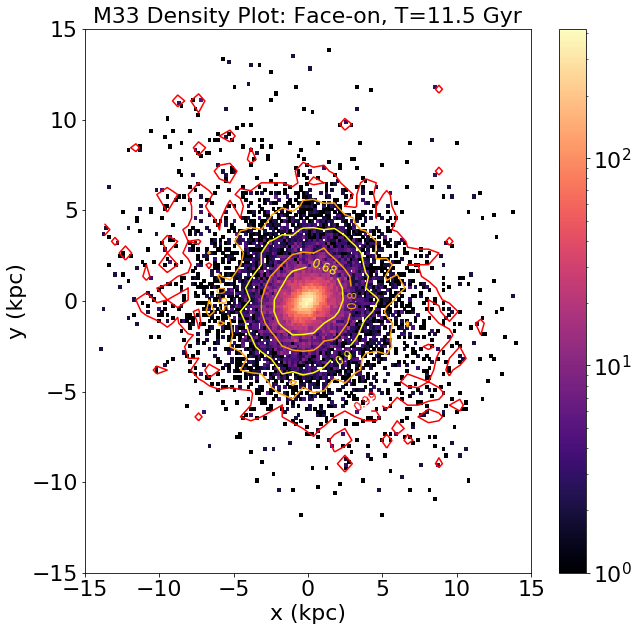

In [5]:
"""
T=11.5 Gyr, Face-On Perpective
"""

# define histogram and contour resolution
histbins = 150
contourbins_x = 40
contourbins_y = 40

# create figure
fig, ax= plt.subplots(figsize=(10,10))
ax.set_title('M33 Density Plot: Face-on, T=11.5 Gyr',fontsize=22)

# plot the particle density for M33 using a 2D historgram
# can modify bin number to make the plot smoother
plt.hist2d(xf, yf, bins=histbins, norm=LogNorm(), cmap='magma')
plt.colorbar()

# overlay density contours
density_contour(xf,yf,contourbins_x,contourbins_y,ax=ax,
                colors=['red','orange', 'yellow', 'orange', 'yellow'])

# Add axis labels
ax.set_xlabel('x (kpc)', fontsize=22)
ax.set_ylabel('y (kpc)', fontsize=22)

#set axis limits
ax.set_ylim(-15,15)
ax.set_xlim(-15,15)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# save plot
plt.savefig('M33DensityFaceOn_final.pdf')

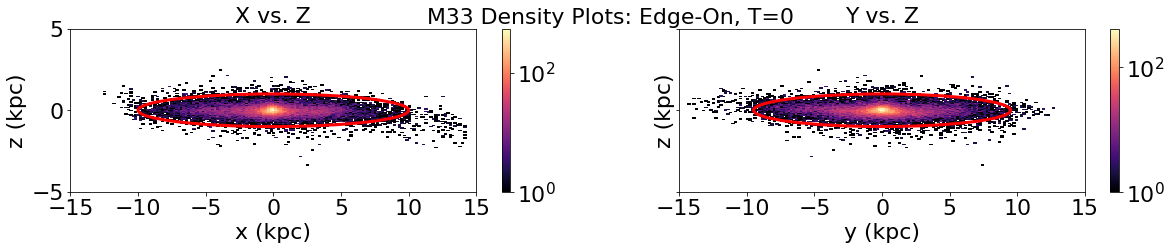

In [6]:
"""
T=0 Edge-On Perpective
"""

# define histogram and contour resolution
histbins = 150
contourbins_xy = 40
contourbins_z = 40

# create figure
fig, ax= plt.subplots(nrows=1,ncols=2,sharex='all',sharey='all',figsize=(20,3))
fig.suptitle('M33 Density Plots: Edge-On, T=0',fontsize=22)

### density plot of X vs Z perspective ###
hist1 = ax[0].hist2d(xi, zi, bins=histbins, norm=LogNorm(), cmap='magma')
# Add axis labels
ax[0].set_title('X vs. Z',fontsize=22)
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('z (kpc)', fontsize=22)
# overlay fitted ellipse
major_x=20
minor_z=2
el_xz = matplotlib.patches.Ellipse((0,0),major_x,minor_z,fill=False,edgecolor='red',linewidth=3)
ax[0].add_patch(el_xz)
#add colorbar
plt.colorbar(hist1[-1],ax=ax[0])

### repeat plot for Y vs. Z perspective ###
hist2 = ax[1].hist2d(yi, zi, bins=histbins, norm=LogNorm(), cmap='magma')
# Add axis labels
ax[1].set_title('Y vs. Z',fontsize=22)
ax[1].set_xlabel('y (kpc)', fontsize=22)
ax[1].set_ylabel('z (kpc)', fontsize=22)
# overlay fitted ellipse
major_y=19
el_yz = matplotlib.patches.Ellipse((0,0),major_y,minor_z,fill=False,edgecolor='red',linewidth=3)
ax[1].add_patch(el_yz)
#add colorbar
plt.colorbar(hist2[-1],ax=ax[1])

# set axis limits
ax[0].set_ylim(-5,5) # sharex/y=True, so changes ax[1] too
ax[0].set_xlim(-15,15)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# save plot
plt.savefig('M33DensityEdgeOn_initial.pdf')

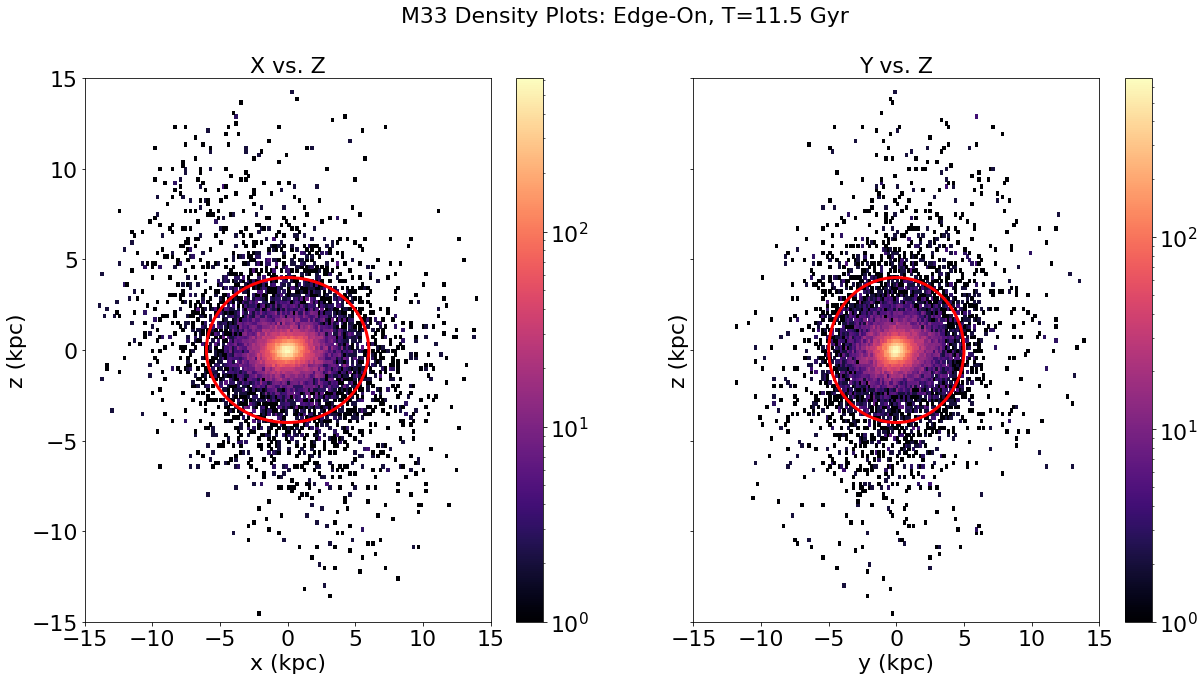

In [7]:
"""
T=11.5 Gyr, Edge-On Perpective
"""

# define histogram and contour resolution
histbins = 150
contourbins_xy = 40
contourbins_z = 40

# create figure
fig, ax= plt.subplots(nrows=1,ncols=2,sharex='all',sharey='all',figsize=(20,10))
fig.suptitle('M33 Density Plots: Edge-On, T=11.5 Gyr',fontsize=22)

### density plot of X vs Z perspective ###
hist1 = ax[0].hist2d(xf, zf, bins=histbins, norm=LogNorm(), cmap='magma')
# Add axis labels
ax[0].set_title('X vs. Z',fontsize=22)
ax[0].set_xlabel('x (kpc)', fontsize=22)
ax[0].set_ylabel('z (kpc)', fontsize=22)
# overlay fitted ellipse
major_x=12
minor_z=8
el_xz = matplotlib.patches.Ellipse((0,0),major_x,minor_z,fill=False,edgecolor='red',linewidth=3)
ax[0].add_patch(el_xz)
#add colorbar
plt.colorbar(hist1[-1],ax=ax[0])

### repeat plot for Y vs. Z perspective ###
hist2 = ax[1].hist2d(yf, zf, bins=histbins, norm=LogNorm(), cmap='magma')
# Add axis labels
ax[1].set_title('Y vs. Z',fontsize=22)
ax[1].set_xlabel('y (kpc)', fontsize=22)
ax[1].set_ylabel('z (kpc)', fontsize=22)
# overlay fitted ellipse
major_y=10
el_yz = matplotlib.patches.Ellipse((0,0),major_y,minor_z,fill=False,edgecolor='red',linewidth=3)
ax[1].add_patch(el_yz)
#add colorbar
plt.colorbar(hist2[-1],ax=ax[1])

# set axis limits
ax[0].set_ylim(-15,15) # sharex/y=True, so changes ax[1] too
ax[0].set_xlim(-15,15)



#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# save plot
plt.savefig('M33DensityEdgeOn_final.pdf')

## Step 4: Measure Axial Ratio

4a. Display a figure with 3 subplots (1 column, 3 rows). Each subplot will be a 1D normalized histogram: axis will display 1D position along one axis, and bin heights will display the particle density. It is important that the range of each subplot match for proper visual inspection.

4b. Measure the inter-quartile range (IQR) for each plot. This is the distance between the 25th and 75th percentiles for position. Plot this distance on top of each histogram. Sanity check: this measure of spread should be robust to outliers and therefore significant mass loss. Regardless, does it seem reasonable?

4c. Calculate and display axial ratios. If the IQR from the last step seems like a reasonable measure of spread, then we will use this as our minor and major ellipse axes. It is ok if these lengths cut out significant mass because the ratio should still be accurate. Display axial ratio calculated from X vs Z and Y vs Z. Check to see that they are similar.

In [8]:
def plotIQR(arr,ax,height):
    """
    Function to calculate the interquartile range of a 1D data set, then plot a line displaying this range on ax
    IQR = 75th percentile - 25th percentile
    inputs:
        arr = 1D array of values
        ax = instance of matplotlib.axes to draw on
        height = y value to draw horizontal line
    returns:
        IQR of the data set
    """
    # sort data to find percentiles
    sortedarr = np.sort(arr,axis=None)
    
    # find the 25th and 75th percentiles
    max_ind = len(arr)-1
    x1 = sortedarr[int(np.ceil(max_ind*0.25))]
    x2 = sortedarr[int(np.ceil(max_ind*0.75))]
    
    # draw a line on the given axes
    ax.plot([x1,x2],[height,height],linewidth=3,color='red',label='IQR')
    
    # return the value for the IQR
    return x2-x1

Approximate Axial Ratios for M33 at T=0
Z/X = 0.1561761011440827
Z/Y = 0.13227537897742328


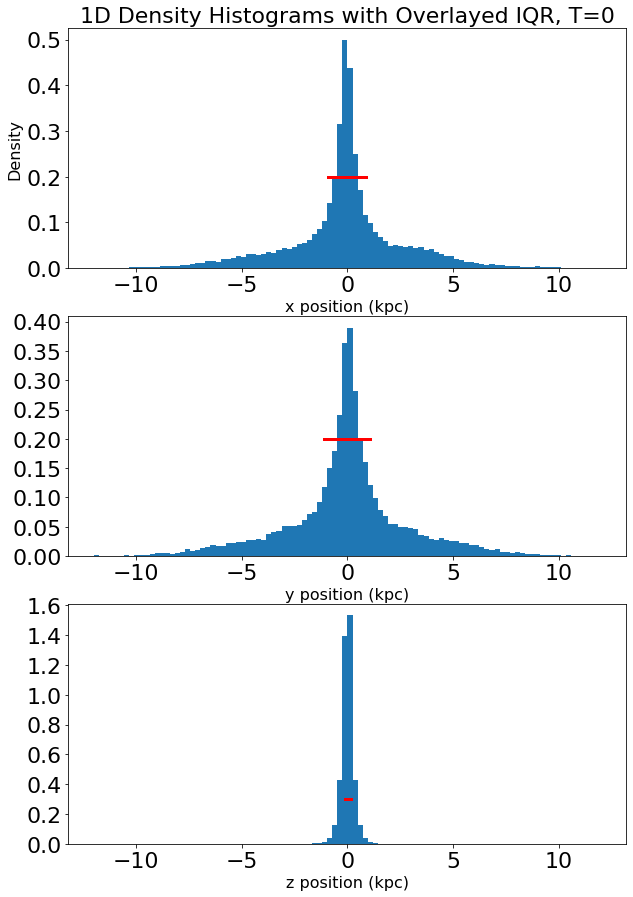

In [9]:
"""
T=0
"""
# create figure with subplots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,15))
ax[0].set_title("1D Density Histograms with Overlayed IQR, T=0",fontsize=22)

# define bins for each subplot
range = (-12,12)
nbins = 100
bin_edges = np.linspace(range[0],range[1],nbins+1)

### x position ###
ax[0].hist(xi,bins=bin_edges,density=True,label='Stellar Density')
ax[0].set_ylabel('Density',fontsize=16)
ax[0].set_xlabel('x position (kpc)',fontsize=16)
IQRx = plotIQR(xi,ax[0],0.2)

### y position ###
ax[1].hist(yi,bins=bin_edges,density=True)
ax[1].set_xlabel('y position (kpc)',fontsize=16)
IQRy = plotIQR(yi,ax[1],0.2)

### z position ###
ax[2].hist(zi,bins=bin_edges,density=True)
ax[2].set_xlabel('z position (kpc)',fontsize=16)
IQRz = plotIQR(zi,ax[2],0.3)

#adjust tick label font size
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add legend to first plot only
#ax[0].legend()

# save figure
plt.savefig('DensityHistograms_initial.pdf')

# calculate approximate axial ratios
print('Approximate Axial Ratios for M33 at T=0')
print('Z/X =',IQRz/IQRx)
print('Z/Y =',IQRz/IQRy)

Approximate Axial Ratios for M33 at T=11.5 Gyr
Z/X = 0.5554595220784584
Z/Y = 0.6749343797162841


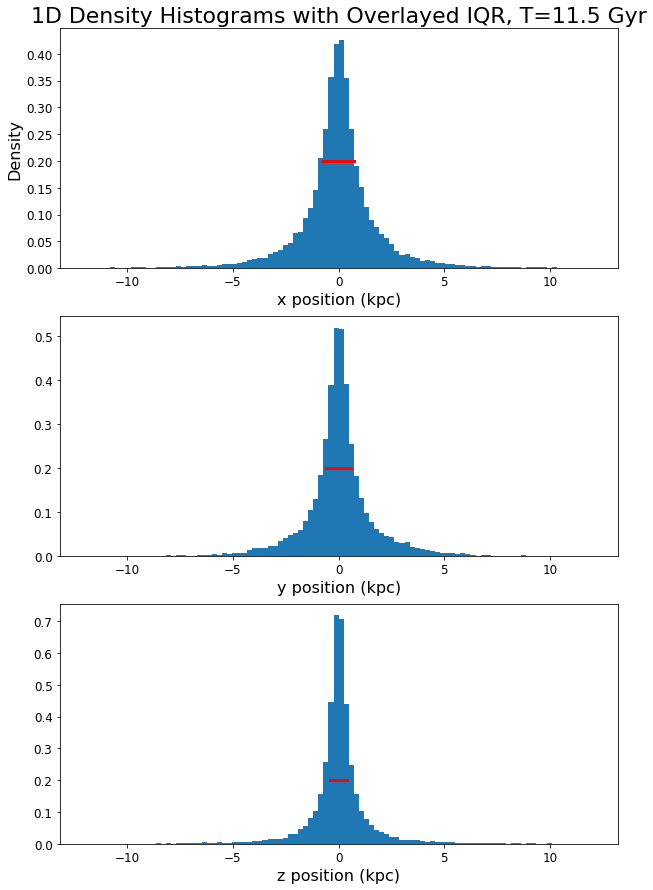

In [10]:
"""
T=11.5 Gyr
"""
# create figure with subplots
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(10,15))
ax[0].set_title("1D Density Histograms with Overlayed IQR, T=11.5 Gyr",fontsize=22)

# using same bins as above

### x position ###
ax[0].hist(xf,bins=bin_edges,density=True)
ax[0].set_ylabel('Density',fontsize=16)
ax[0].set_xlabel('x position (kpc)',fontsize=16)
IQRx = plotIQR(xf,ax[0],0.2)

### y position ###
ax[1].hist(yf,bins=bin_edges,density=True)
ax[1].set_xlabel('y position (kpc)',fontsize=16)
IQRy = plotIQR(yf,ax[1],0.2)

### z position ###
ax[2].hist(zf,bins=bin_edges,density=True)
ax[2].set_xlabel('z position (kpc)',fontsize=16)
IQRz = plotIQR(zf,ax[2],0.2)

#adjust tick label font size
label_size = 12
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# save figure
plt.savefig('DensityHistograms_initial.pdf')

# calculate approximate axial ratios
print('Approximate Axial Ratios for M33 at T=11.5 Gyr')
print('Z/X =',IQRz/IQRx)
print('Z/Y =',IQRz/IQRy)